### Install Required Python Packages

In [13]:
# !pip install biopython
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn

### Import Required Libraries

In [1]:
from Bio import Entrez, SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
Entrez.email = "chetan.elenki@utah.edu"

### Download Genome Sequences

In [11]:
def download_genome_sequence(accession):
    """Download genome sequence from GenBank"""
    handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
    return SeqIO.read(handle, "genbank")

# Download the three genome sequences
accessions = ["CP070375.1", "CP070376.1", "CP070377.1", "U00096","CP002175.1"]
genome_records = {}

for acc in accessions:
    genome_records[acc] = download_genome_sequence(acc)
    print(f"Downloaded sequence: {acc}")

Downloaded sequence: CP070375.1
Downloaded sequence: CP070376.1
Downloaded sequence: CP070377.1
Downloaded sequence: U00096
Downloaded sequence: CP002175.1


In [6]:
# Debugging: Print all product descriptions for the first genome record
for feature in genome_records["CP070375.1"].features:
    if feature.type == "CDS":
        print(feature.qualifiers.get("product", ["No product description"])[0])


DNA primase
ATP-binding protein
VirB4 family type IV secretion system protein
hypothetical protein
hypothetical protein
hypothetical protein
hypothetical protein
hypothetical protein
hypothetical protein
exodeoxyribonuclease VII large subunit
hypothetical protein
26S protease regulatory subunit
hypothetical protein
site-specific integrase
hypothetical protein
helix-turn-helix domain-containing protein
SIR2 family protein
DUF4365 domain-containing protein
DNA cytosine methyltransferase
phospholipase D family protein
hypothetical protein
helicase
DrmE family protein
orc1/cdc6 family replication initiation protein
ParA family protein
hypothetical protein
hypothetical protein
hypothetical protein
hypothetical protein
hypothetical protein
hypothetical protein
DNA polymerase I
AAA family ATPase
hypothetical protein
PIN domain-containing protein
AbrB/MazE/SpoVT family DNA-binding domain-containing protein
universal stress protein
hypothetical protein
AAA family ATPase
TrkA family potassium up

In [8]:
def extract_relevant_genes(genome_record):
    """Extract genes related to stress response, transporters, or gas vesicle proteins."""
    relevant_genes = []
    # Keywords to identify relevant genes
    keywords = ["stress", "gas vesicle", "potassium", "transport", "haloarchaea", "hypersaline", "ABC transporter"]
    
    for feature in genome_record.features:
        if feature.type == "CDS":  # Look at coding sequences
            product = feature.qualifiers.get("product", [""])[0].lower()
            if any(keyword in product for keyword in keywords):
                locus_tag = feature.qualifiers.get("locus_tag", ["N/A"])[0]
                relevant_genes.append({
                    "locus_tag": locus_tag,
                    "product": product
                })
    return relevant_genes

# Extract genes matching the updated criteria
all_relevant_genes = {}

for acc, record in genome_records.items():
    relevant_genes = extract_relevant_genes(record)
    all_relevant_genes[acc] = relevant_genes
    print(f"Identified {len(relevant_genes)} relevant genes in {acc}.")

# Print the identified genes
for acc, genes in all_relevant_genes.items():
    print(f"\nAccession: {acc}")
    for gene in genes:
        print(f"Locus Tag: {gene['locus_tag']}, Product: {gene['product']}")


Identified 55 relevant genes in CP070375.1.
Identified 0 relevant genes in CP070376.1.
Identified 133 relevant genes in CP070377.1.

Accession: CP070375.1
Locus Tag: JT689_00185, Product: universal stress protein
Locus Tag: JT689_00200, Product: trka family potassium uptake protein
Locus Tag: JT689_00205, Product: potassium-transporting atpase subunit f
Locus Tag: JT689_00210, Product: potassium-transporting atpase subunit kdpa
Locus Tag: JT689_00215, Product: potassium-transporting atpase subunit kdpb
Locus Tag: JT689_00220, Product: potassium-transporting atpase subunit c
Locus Tag: JT689_00225, Product: universal stress protein
Locus Tag: JT689_00250, Product: universal stress protein
Locus Tag: JT689_00290, Product: inorganic phosphate transporter
Locus Tag: JT689_00310, Product: universal stress protein
Locus Tag: JT689_00360, Product: trka family potassium uptake protein
Locus Tag: JT689_00370, Product: trka family potassium uptake protein
Locus Tag: JT689_00385, Product: gas ves

In [9]:
# Filter gas vesicle-related genes
def filter_gas_vesicle_genes(relevant_genes):
    """Filter and return only gas vesicle-related genes."""
    gas_vesicle_genes = [gene for gene in relevant_genes if "gas vesicle" in gene["product"]]
    return gas_vesicle_genes

# Isolate gas vesicle genes for each accession
gas_vesicle_genes = {}
for acc, genes in all_relevant_genes.items():
    gas_vesicle_genes[acc] = filter_gas_vesicle_genes(genes)
    print(f"Identified {len(gas_vesicle_genes[acc])} gas vesicle-related genes in {acc}.")

# Output the gas vesicle genes
for acc, genes in gas_vesicle_genes.items():
    print(f"\nAccession: {acc}")
    for gene in genes:
        print(f"Locus Tag: {gene['locus_tag']}, Product: {gene['product']}")


Identified 14 gas vesicle-related genes in CP070375.1.
Identified 0 gas vesicle-related genes in CP070376.1.
Identified 0 gas vesicle-related genes in CP070377.1.

Accession: CP070375.1
Locus Tag: JT689_00385, Product: gas vesicle protein
Locus Tag: JT689_00390, Product: gas vesicle protein gvpl
Locus Tag: JT689_00395, Product: gas vesicle protein k
Locus Tag: JT689_00400, Product: gas vesicle protein gvpj
Locus Tag: JT689_00405, Product: gas vesicle protein gvpi
Locus Tag: JT689_00410, Product: gas vesicle protein gvph
Locus Tag: JT689_00415, Product: gas vesicle protein gvpg
Locus Tag: JT689_00420, Product: gas vesicle protein gvpf
Locus Tag: JT689_00425, Product: gas vesicle transcriptional activator gvpe
Locus Tag: JT689_00430, Product: gas vesicle protein gvpd
Locus Tag: JT689_00435, Product: gas vesicle structural protein gvpa
Locus Tag: JT689_00440, Product: gas vesicle protein gvpc
Locus Tag: JT689_00445, Product: gas vesicle protein gvpn
Locus Tag: JT689_00450, Product: gas ve

In [12]:
from Bio import Entrez, SeqIO, pairwise2
from Bio.Blast import NCBIWWW, NCBIXML

# Step 1: Define gas vesicle locus tags and flanking region size
gas_vesicle_loci = ["JT689_00385", "JT689_00390", "JT689_00395", "JT689_00400",
                    "JT689_00405", "JT689_00410", "JT689_00415", "JT689_00420",
                    "JT689_00425", "JT689_00430", "JT689_00435", "JT689_00440",
                    "JT689_00445", "JT689_00450"]
flank_size = 10000  # 10 kb

# Step 2: Extract genomic regions surrounding gas vesicle genes
def extract_flanking_regions(genome_record, loci, flank_size):
    regions = {}
    for feature in genome_record.features:
        if feature.type == "CDS" and feature.qualifiers.get("locus_tag", [None])[0] in loci:
            start = max(0, feature.location.start - flank_size)
            end = min(len(genome_record.seq), feature.location.end + flank_size)
            regions[feature.qualifiers["locus_tag"][0]] = genome_record.seq[start:end]
    return regions

# Fetch genome record for Halobacterium sp. GSL-19 (example for one chromosome)
halobacterium_record = genome_records["CP070375.1"]
flanking_regions = extract_flanking_regions(halobacterium_record, gas_vesicle_loci, flank_size)

# Step 3: Pairwise alignment example
for locus, region in flanking_regions.items():
    print(f"Analyzing locus: {locus}")
    # Example: Compare to E. coli genome
    ecoli_region = genome_records["U00096"].seq[:len(region)]  # Truncated for simplicity
    alignments = pairwise2.align.globalxx(region, ecoli_region)
    print(f"Alignment score for {locus}: {alignments[0].score}")

# Step 4: Functional annotation (use BLAST for alignment to databases)
for locus, region in flanking_regions.items():
    print(f"Running BLAST for locus: {locus}")
    result_handle = NCBIWWW.qblast("blastn", "nt", str(region))
    blast_record = NCBIXML.read(result_handle)
    for alignment in blast_record.alignments[:5]:  # Top 5 matches
        print(f"Match: {alignment.title}, Score: {alignment.hsps[0].score}")


Analyzing locus: JT689_00385
Alignment score for JT689_00385: 13056.0
Analyzing locus: JT689_00390
Alignment score for JT689_00390: 13454.0
Analyzing locus: JT689_00395
Alignment score for JT689_00395: 13156.0
Analyzing locus: JT689_00400
Alignment score for JT689_00400: 13122.0
Analyzing locus: JT689_00405
Alignment score for JT689_00405: 13155.0
Analyzing locus: JT689_00410
Alignment score for JT689_00410: 13245.0
Analyzing locus: JT689_00415
Alignment score for JT689_00415: 13099.0
Analyzing locus: JT689_00420
Alignment score for JT689_00420: 13370.0
Analyzing locus: JT689_00425
Alignment score for JT689_00425: 13308.0
Analyzing locus: JT689_00430
Alignment score for JT689_00430: 13873.0
Analyzing locus: JT689_00435
Alignment score for JT689_00435: 13063.0
Analyzing locus: JT689_00440
Alignment score for JT689_00440: 13475.0
Analyzing locus: JT689_00445
Alignment score for JT689_00445: 13602.0
Analyzing locus: JT689_00450
Alignment score for JT689_00450: 13155.0
Running BLAST for lo

### Basic Sequence Analysis

In [16]:
# Analyze each sequence
for acc, record in genome_records.items():
    print(f"\nAnalyzing sequence: {acc}")
    print(f"Sequence length: {len(record.seq)} bp")
    print(f"GC content: {(record.seq.count('G') + record.seq.count('C')) / len(record.seq) * 100:.2f}%")
    print(f"Number of features: {len(record.features)}")


Analyzing sequence: CP070375.1
Sequence length: 284178 bp
GC content: 59.07%
Number of features: 549

Analyzing sequence: CP070376.1
Sequence length: 54914 bp
GC content: 61.37%
Number of features: 122

Analyzing sequence: CP070377.1
Sequence length: 1987132 bp
GC content: 67.99%
Number of features: 4247


#### Analysis notes-1:

##### Genome Organization: 
The genome is split into three components:
* CP070377.1: Main chromosome (1,987,132 bp)
* CP070375.1: Plasmid 1 (284,178 bp)
* CP070376.1: Plasmid 2 (54,914 bp)

##### GC Content Analysis:
Main chromosome (CP070377.1): 67.99%
Plasmid 1 (CP070375.1): 59.07%
Plasmid 2 (CP070376.1): 61.37%

The high GC content, particularly in the main chromosome (67.99%), is a significant halophilic adaptation because:
* High GC content provides greater DNA stability in high salt conditions [1]
* Helps prevent thymine dimers from forming under intense UV radiation (common in hypersaline environments) [2][3]
* Contributes to protein stability in high salt conditions [4][5]

##### References:
[1] Paul, S., Bag, S. K., Das, S., Harvill, E. T., & Dutta, C. (2008). Molecular signature of hypersaline adaptation: insights from genome and proteome composition of halophilic prokaryotes. Genome Biology, 9(4), R70.
> This paper demonstrates how high GC content provides structural stability to DNA in hypersaline conditions
> Shows statistical correlation between environmental salt concentration and genomic GC content in halophiles

[2] Jones, D. L., & Baxter, B. K. (2017). DNA Repair and Photoprotection: Mechanisms of Overcoming Environmental Ultraviolet Radiation Exposure in Halophilic Archaea. Frontiers in Microbiology, 8, 1882.
> Explains how GC pairs are more resistant to UV-induced damage than AT pairs
> Details the mechanisms of DNA protection in halophilic environments

[3] DasSarma, S., & DasSarma, P. (2015). Halophiles and their enzymes: negativity put to good use. Current Opinion in Microbiology, 25, 120-126.
> Discusses various molecular adaptations of halophiles, including DNA stability mechanisms

[4] Hickey, D. A., & Singer, G. A. (2004). Genomic and proteomic adaptations to growth at high temperature. Genome Biology, 5(10), 117.
> While primarily focused on thermophiles, this paper explains how GC content affects amino acid usage and protein stability

[5] Suprasanna, P., Nikalje, G. C., & Rai, A. N. (2016). Osmolyte accumulation and implications in plant abiotic stress tolerance. In Osmolytes and Plants Acclimation to Changing Environment: Emerging Omics Technologies (pp. 1-12). Springer, New Delhi.
> Discusses how GC-rich codons often code for amino acids that contribute to protein stability in high-salt conditions


### Feature Analysis

In [17]:
def analyze_features(record):
    """Analyze features in the genome record"""
    feature_types = {}
    for feature in record.features:
        if feature.type in feature_types:
            feature_types[feature.type] += 1
        else:
            feature_types[feature.type] = 1
    return feature_types

# Create feature analysis for each sequence
for acc, record in genome_records.items():
    print(f"\nFeature analysis for {acc}:")
    features = analyze_features(record)
    for feature_type, count in features.items():
        print(f"{feature_type}: {count}")


Feature analysis for CP070375.1:
source: 1
gene: 274
CDS: 274

Feature analysis for CP070376.1:
source: 1
gene: 59
CDS: 59
repeat_region: 3

Feature analysis for CP070377.1:
source: 1
gene: 2123
CDS: 2071
tRNA: 47
ncRNA: 2
rRNA: 3


### Visualize Feature Distribution

<Figure size 1200x600 with 0 Axes>

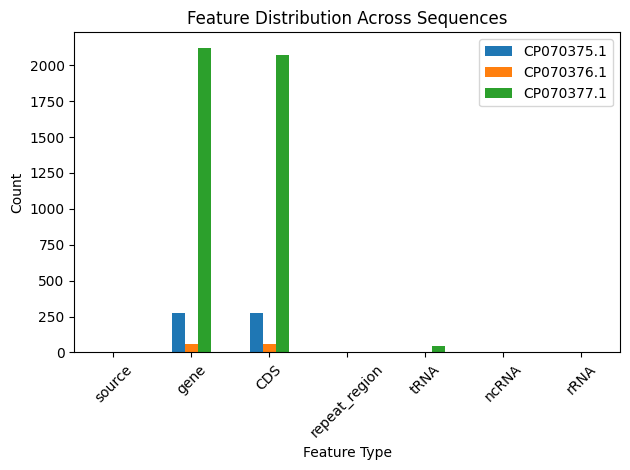

In [18]:
# Create a bar plot of feature distribution
def plot_feature_distribution(genome_records):
    plt.figure(figsize=(12, 6))
    
    feature_counts = {}
    for acc, record in genome_records.items():
        features = analyze_features(record)
        feature_counts[acc] = features
    
    df = pd.DataFrame(feature_counts)
    df.plot(kind='bar')
    plt.title('Feature Distribution Across Sequences')
    plt.xlabel('Feature Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_distribution(genome_records)

#### Analysis Notes-2:

##### Feature Distribution:

Main Chromosome (CP070377.1):
* 2,123 genes
* 2,071 coding sequences (CDS)
* 47 tRNAs
* 2 ncRNAs
* 3 rRNAs

Plasmid 1 (CP070375.1):
* 274 genes
* 274 CDS

Plasmid 2 (CP070376.1):
* 59 genes
* 59 CDS
* 3 repeat regions

#### Next Steps:

1. Additional references to literature
   * Oren, A. (2008). Microbial life at high salt concentrations: phylogenetic and metabolic diversity. Saline Systems, 4(1), 2.
     * A classic review covering multiple aspects of halophilic adaptations. Includes discussion of genomic features including GC content

   * Gunde-Cimerman, N., Plemenitaš, A., & Oren, A. (2018). Strategies of adaptation of microorganisms of the three domains of life to high salt concentrations. FEMS Microbiology Reviews, 42(3), 353-375.
     * A more recent comprehensive review. Connects genomic features to protein-level adaptations

2. Potential Halophilic Adaptation Mechanisms (need to analyze the specific genes for these):
    * Osmotic Balance:
      * Potential genes involved in:
        * Compatible solute synthesis (e.g., glycine betaine)
        * K+ accumulation systems
        * Na+/H+ antiporters


    * Protein Adaptations:
      * Search for proteins with:
        * Negative surface charge (high Asp/Glu content)
        * Reduced hydrophobic amino acids
        * Modified protein folding mechanisms


   * Membrane Adaptations:
     * Genes for:
       * Specialized lipid synthesis
       * Carotenoid production
       * Cell wall modifications

In [1]:
import pandas as pd
from Bio import SeqIO, Entrez
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import defaultdict

class HalophilicAdaptationAnalyzer:
    """
    This class analyzes genomic and protein features related to halophilic adaptations.
    """
    def __init__(self):
        # Define known patterns for osmotic balance and membrane adaptation mechanisms.
        # These patterns help identify genes involved in specific adaptation mechanisms.
        self.osmotic_balance_patterns = {
            'betaine': ['betaine', 'glycine betaine', 'gbt', 'bet'],
            'potassium': ['trk', 'kdp', 'kef', 'ktr'],
            'antiporter': ['nha', 'anti', 'porter', 'nhaC', 'nhaD']
        }
        
        self.membrane_adaptation_patterns = {
            'lipid_synthesis': ['ips', 'dps', 'crt', 'mva', 'dgk'],
            'carotenoid': ['crt', 'lyc', 'car'],
            'cell_wall': ['acs', 'mur', 'peptidoglycan']
        }
        
        # Define amino acid classifications for protein adaptation analysis.
        self.acidic_aa = ['D', 'E']  # Aspartate (D) and Glutamate (E) are acidic.
        self.hydrophobic_aa = ['A', 'I', 'L', 'M', 'F', 'W', 'V']  # Common hydrophobic residues.

    def analyze_osmotic_balance_genes(self, genome_record):
        """
        Identify genes involved in osmotic balance by searching for specific patterns in gene and product names.
        """
        osmotic_genes = defaultdict(list)  # Organize genes by adaptation mechanism.

        for feature in genome_record.features:
            if feature.type == "CDS":  # CDS (Coding Sequence) features contain gene and product information.
                product = feature.qualifiers.get('product', [''])[0].lower()
                gene = feature.qualifiers.get('gene', [''])[0].lower()
                
                # Check for known patterns in product or gene names.
                for mechanism, patterns in self.osmotic_balance_patterns.items():
                    if any(pattern in product or pattern in gene for pattern in patterns):
                        gene_info = {
                            'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                            'product': product,
                            'gene': gene,
                            'location': str(feature.location)
                        }
                        osmotic_genes[mechanism].append(gene_info)
        
        return osmotic_genes

    def analyze_protein_adaptations(self, genome_record):
        """
        Analyze proteins for characteristics associated with halophilic adaptations.
        """
        protein_features = []  # Store features of all analyzed proteins.

        for feature in genome_record.features:
            if feature.type == "CDS" and 'translation' in feature.qualifiers:
                protein_seq = feature.qualifiers['translation'][0]  # Extract protein sequence.
                
                try:
                    # Use BioPython's ProteinAnalysis for feature computation.
                    protein_analysis = ProteinAnalysis(protein_seq)
                    
                    # Calculate specific features.
                    acidic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.acidic_aa)
                    hydrophobic_content = sum(protein_analysis.count_amino_acids()[aa] for aa in self.hydrophobic_aa)
                    
                    # Store calculated features.
                    protein_info = {
                        'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                        'product': feature.qualifiers.get('product', ['Unknown'])[0],
                        'length': len(protein_seq),
                        'acidic_percentage': (acidic_content / len(protein_seq)) * 100,
                        'hydrophobic_percentage': (hydrophobic_content / len(protein_seq)) * 100,
                        'instability_index': protein_analysis.instability_index(),
                        'gravy': protein_analysis.gravy()  # GRAVY (Grand Average of Hydropathy)
                    }
                    protein_features.append(protein_info)
                    
                except Exception as e:
                    print(f"Error analyzing protein {feature.qualifiers.get('locus_tag', ['Unknown'])[0]}: {str(e)}")
        
        # Return results as a DataFrame for easy analysis.
        return pd.DataFrame(protein_features)

    def analyze_membrane_adaptations(self, genome_record):
        """
        Identify genes involved in membrane adaptations by searching for specific patterns in gene and product names.
        """
        membrane_genes = defaultdict(list)  # Organize genes by adaptation mechanism.

        for feature in genome_record.features:
            if feature.type == "CDS":
                product = feature.qualifiers.get('product', [''])[0].lower()
                gene = feature.qualifiers.get('gene', [''])[0].lower()
                
                # Check for known patterns in product or gene names.
                for mechanism, patterns in self.membrane_adaptation_patterns.items():
                    if any(pattern in product or pattern in gene for pattern in patterns):
                        gene_info = {
                            'locus_tag': feature.qualifiers.get('locus_tag', ['Unknown'])[0],
                            'product': product,
                            'gene': gene,
                            'location': str(feature.location)
                        }
                        membrane_genes[mechanism].append(gene_info)
        
        return membrane_genes

    def generate_summary_report(self, osmotic_genes, protein_features_df, membrane_genes):
        """
        Generate a summary report of osmotic balance genes, protein adaptations, and membrane adaptations.
        """
        report = {
            'osmotic_balance': {
                'total_genes': sum(len(genes) for genes in osmotic_genes.values()),
                'mechanism_breakdown': {mech: len(genes) for mech, genes in osmotic_genes.items()}
            },
            'protein_adaptations': {
                'total_proteins': len(protein_features_df),
                'avg_acidic_content': protein_features_df['acidic_percentage'].mean(),
                'avg_hydrophobic_content': protein_features_df['hydrophobic_percentage'].mean(),
                'highly_acidic_proteins': len(protein_features_df[protein_features_df['acidic_percentage'] > 15])
            },
            'membrane_adaptations': {
                'total_genes': sum(len(genes) for genes in membrane_genes.values()),
                'mechanism_breakdown': {mech: len(genes) for mech, genes in membrane_genes.items()}
            }
        }
        return report

def main():
    """
    Main function to execute the analysis for given genomic sequences.
    """
    # Initialize the analyzer
    analyzer = HalophilicAdaptationAnalyzer()
    
    # Set email for NCBI Entrez usage.
    Entrez.email = "chetan.elenki@gmail.com" # Update with your email address.
    
    # List of accession numbers for genomic sequences.
    accessions = ["CP070375.1", "CP070376.1", "CP070377.1"]
    # TODO: research NRC1 and other halophilic archaea for more accessions
    
    for acc in accessions:
        print(f"\nAnalyzing sequence: {acc}")
        
        # Fetch the GenBank record from NCBI.
        handle = Entrez.efetch(db="nucleotide", id=acc, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        
        # Perform analyses on the genome record.
        osmotic_genes = analyzer.analyze_osmotic_balance_genes(record)
        protein_features = analyzer.analyze_protein_adaptations(record)
        membrane_genes = analyzer.analyze_membrane_adaptations(record)
        
        # Generate and display the summary report.
        summary = analyzer.generate_summary_report(osmotic_genes, protein_features, membrane_genes)
        
        print("\nSummary Report:")
        print(f"Osmotic Balance Genes: {summary['osmotic_balance']['total_genes']}")
        print("Mechanism Breakdown:", summary['osmotic_balance']['mechanism_breakdown'])
        
        print("\nProtein Adaptations:")
        print(f"Total proteins analyzed: {summary['protein_adaptations']['total_proteins']}")
        print(f"Average acidic content: {summary['protein_adaptations']['avg_acidic_content']:.2f}%")
        print(f"Highly acidic proteins: {summary['protein_adaptations']['highly_acidic_proteins']}")
        
        print("\nMembrane Adaptation Genes:")
        print("Mechanism Breakdown:", summary['membrane_adaptations']['mechanism_breakdown'])

if __name__ == "__main__":
    main()



Analyzing sequence: CP070375.1

Summary Report:
Osmotic Balance Genes: 50
Mechanism Breakdown: {'potassium': 8, 'betaine': 6, 'antiporter': 36}

Protein Adaptations:
Total proteins analyzed: 249
Average acidic content: 16.39%
Highly acidic proteins: 168

Membrane Adaptation Genes:
Mechanism Breakdown: {'carotenoid': 10}

Analyzing sequence: CP070376.1

Summary Report:
Osmotic Balance Genes: 0
Mechanism Breakdown: {}

Protein Adaptations:
Total proteins analyzed: 57
Average acidic content: 18.17%
Highly acidic proteins: 45

Membrane Adaptation Genes:
Mechanism Breakdown: {}

Analyzing sequence: CP070377.1

Summary Report:
Osmotic Balance Genes: 165
Mechanism Breakdown: {'antiporter': 134, 'potassium': 6, 'betaine': 25}

Protein Adaptations:
Total proteins analyzed: 2061
Average acidic content: 15.80%
Highly acidic proteins: 1299

Membrane Adaptation Genes:
Mechanism Breakdown: {'carotenoid': 100, 'lipid_synthesis': 3, 'cell_wall': 1}


1. **Main Chromosome (CP070377.1)** - Largest component (1.99 Mb):

A. Osmotic Balance (165 genes):
- 134 antiporter genes: Large number indicates robust Na+/H+ exchange system
- 6 potassium transport genes: K+ accumulation mechanisms
- 25 betaine-related genes: Significant compatible solute synthesis capacity

B. Protein Adaptations:
- 2,061 proteins analyzed
- 15.80% average acidic content
- 1,299 (63%) highly acidic proteins
  * This high proportion suggests widespread adaptation for protein stability in high salt

C. Membrane Adaptations:
- 100 carotenoid-related genes: Extensive UV protection system
- 3 lipid synthesis genes
- 1 cell wall modification gene

2. **Plasmid 1 (CP070375.1)** - Medium sized (284 Kb):

A. Osmotic Balance (50 genes):
- 36 antiporter genes
- 8 potassium transport genes
- 6 betaine-related genes
  * High concentration of osmotic regulation genes for plasmid size

B. Protein Adaptations:
- 249 proteins analyzed
- 16.39% average acidic content (highest among all three components)
- 168 (67%) highly acidic proteins

C. Membrane Adaptations:
- 10 carotenoid-related genes

3. **Plasmid 2 (CP070376.1)** - Smallest (55 Kb):

A. Osmotic Balance:
- No osmotic balance genes detected

B. Protein Adaptations:
- 57 proteins analyzed
- 18.17% average acidic content (notably high)
- 45 (79%) highly acidic proteins
  * Highest proportion of acidic proteins among all components

C. Membrane Adaptations:
- No membrane adaptation genes detected

**Key Insights about GSL-19's Halophilic Adaptations:**

1. **Multi-layered Osmotic Balance Strategy**:
- Dominant use of antiporters (170 total across genome)
- Complementary systems of K+ transport and compatible solute synthesis
- Strategic distribution across chromosome and Plasmid 1

2. **Protein Acidification Pattern**:
- Consistently high acidic content across all replicons (15.80-18.17%)
- Higher proportion of acidic proteins in plasmids
- Total of 1,512 highly acidic proteins across the genome

3. **Membrane Protection Systems**:
- Strong emphasis on carotenoid production (110 genes total)
- Limited but present lipid synthesis and cell wall modification genes
- Concentration of membrane adaptation genes in main chromosome

4. **Plasmid Specialization**:
- Plasmid 1: Significant role in osmotic balance and protein adaptation
- Plasmid 2: Specialized for highly acidic proteins
- Suggests plasmid-based enhancement of halophilic capabilities

**Unique Features of GSL-19:**
1. Extensive antiporter system (170 genes) suggests highly efficient Na+ exclusion
2. High proportion of acidic proteins across all replicons indicates robust protein stability
3. Large carotenoid gene repertoire suggests strong UV/oxidative stress protection

### **Overall Summary**

| Metric                         | CP070375.1  | CP070376.1 | CP070377.1  |
|--------------------------------|-------------|------------|-------------|
| **Osmotic Balance Genes**      | 50          | 0          | 165         |
| **Dominant Mechanism**         | Antiporter  | None       | Antiporter  |
| **Total Proteins Analyzed**    | 249         | 57         | 2,061       |
| **Avg. Acidic Content**        | 16.39%      | 18.17%     | 15.80%      |
| **Highly Acidic Proteins**     | 168         | 45         | 1,299       |
| **Membrane Genes**             | 10 carotenoid | None      | 100 carotenoid, 3 lipid, 1 cell wall |

**Biological Implications**:
1. **CP070375.1** and **CP070377.1** exhibit strong halophilic characteristics, with abundant osmotic balance genes, acidic proteins, and membrane adaptations.
2. **CP070376.1** shows minimal genomic features linked to halophilic adaptation, though its proteins demonstrate high acidic content, suggesting intrinsic solubility in saline conditions.

## Comparative Genomic Analysis 
### (Work in Progress)

Starting comparative genomic analysis...

Analyzing extreme_halophile (CP070377.1)...
Basic statistics for extreme_halophile:
  genome_size: 1987132
  gc_content: 67.99160800591002
  gene_count: 2123
  protein_count: 2071

Analyzing plasmid_1 (CP070375.1)...
Basic statistics for plasmid_1:
  genome_size: 284178
  gc_content: 59.074242200311076
  gene_count: 274
  protein_count: 274

Analyzing plasmid_2 (CP070376.1)...
Basic statistics for plasmid_2:
  genome_size: 54914
  gc_content: 61.37414866882762
  gene_count: 59
  protein_count: 59

Generating visualizations...


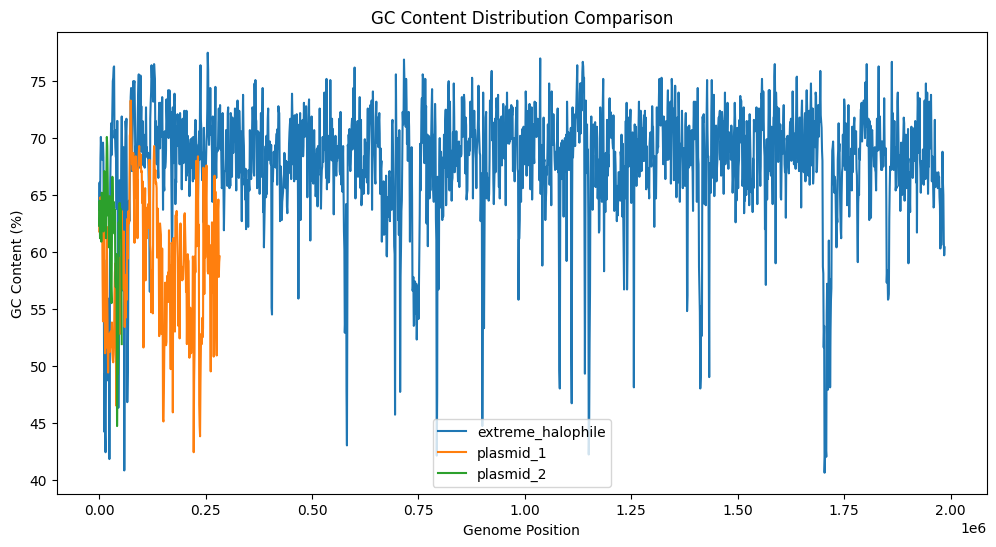

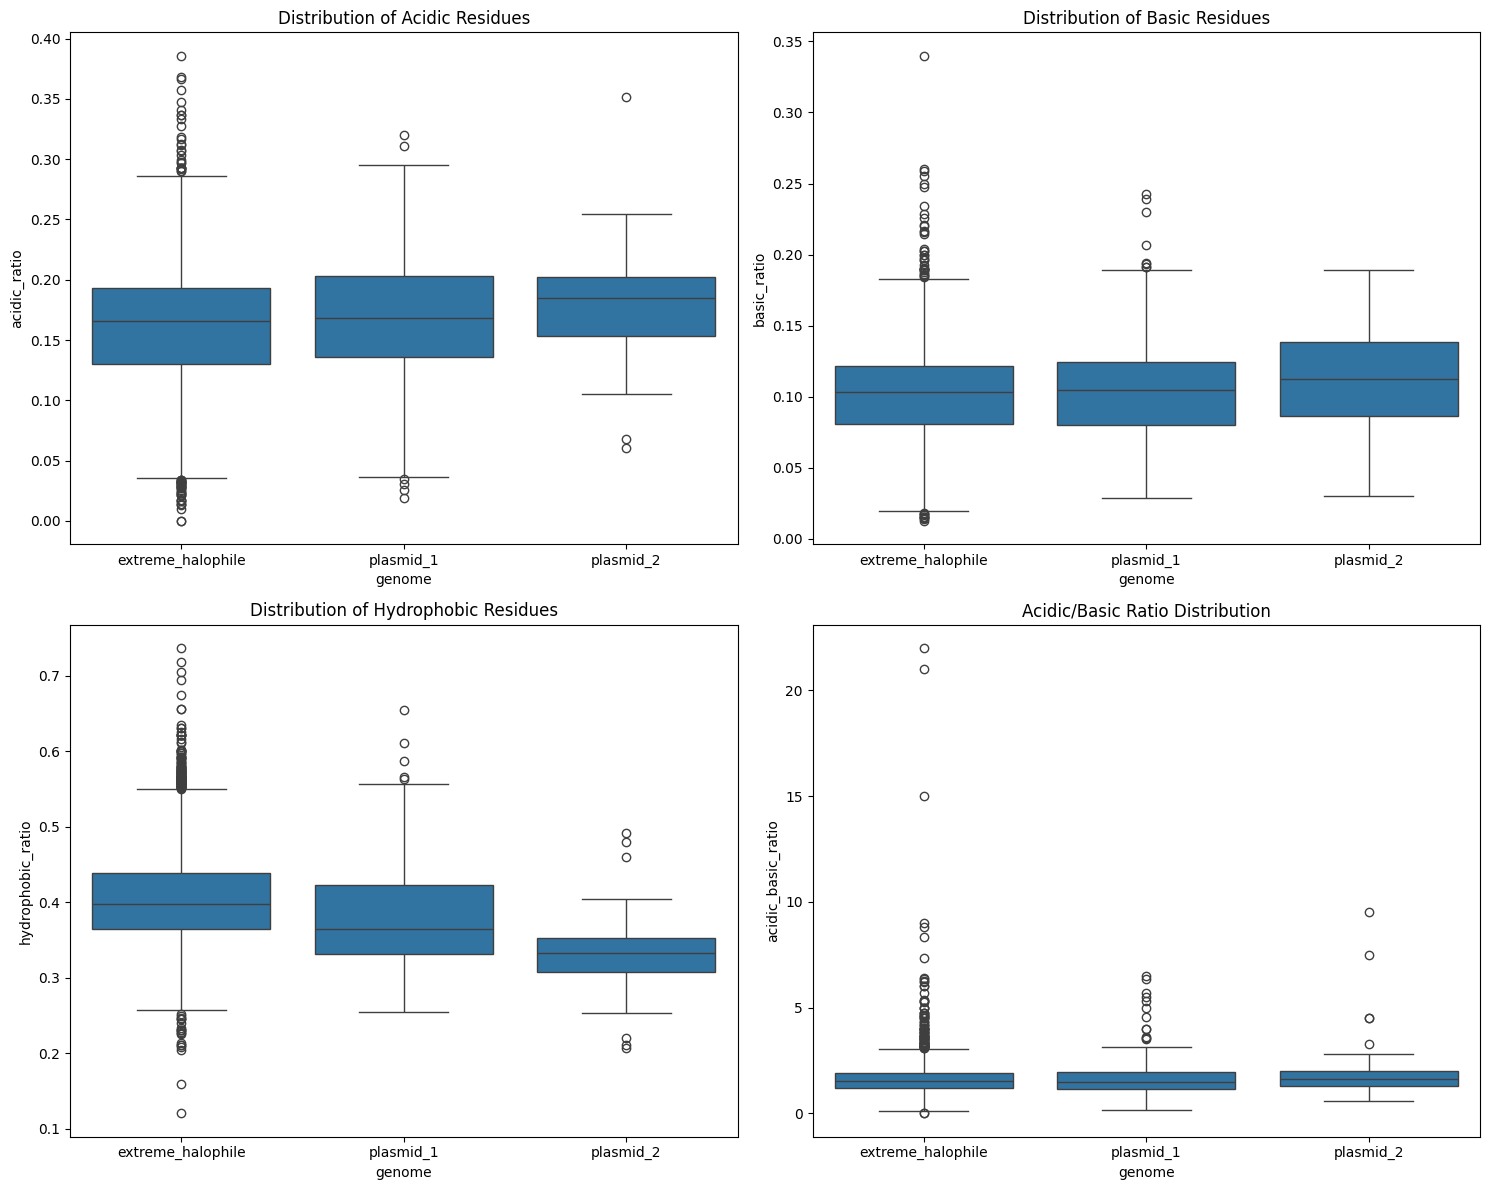

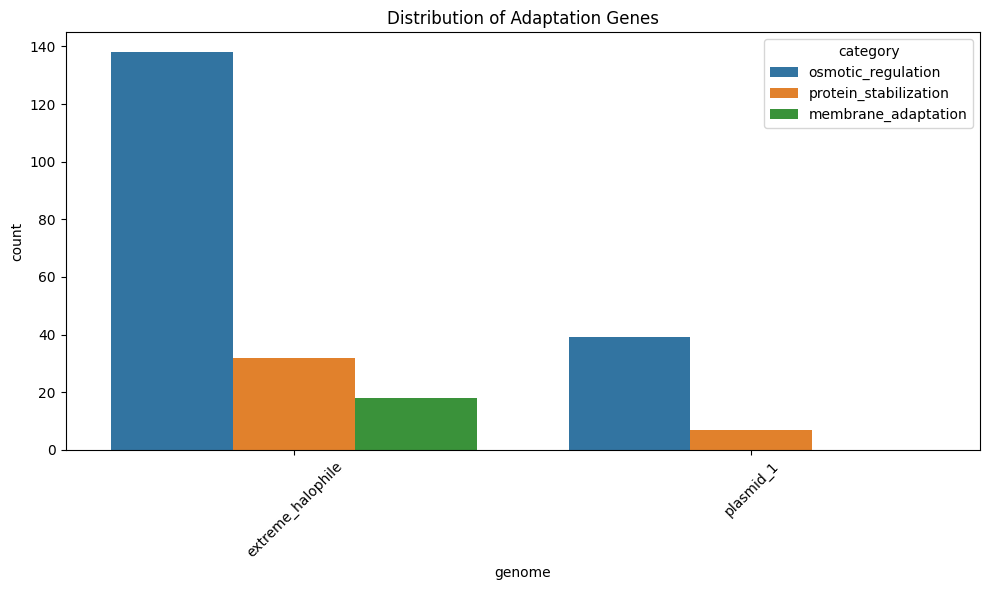

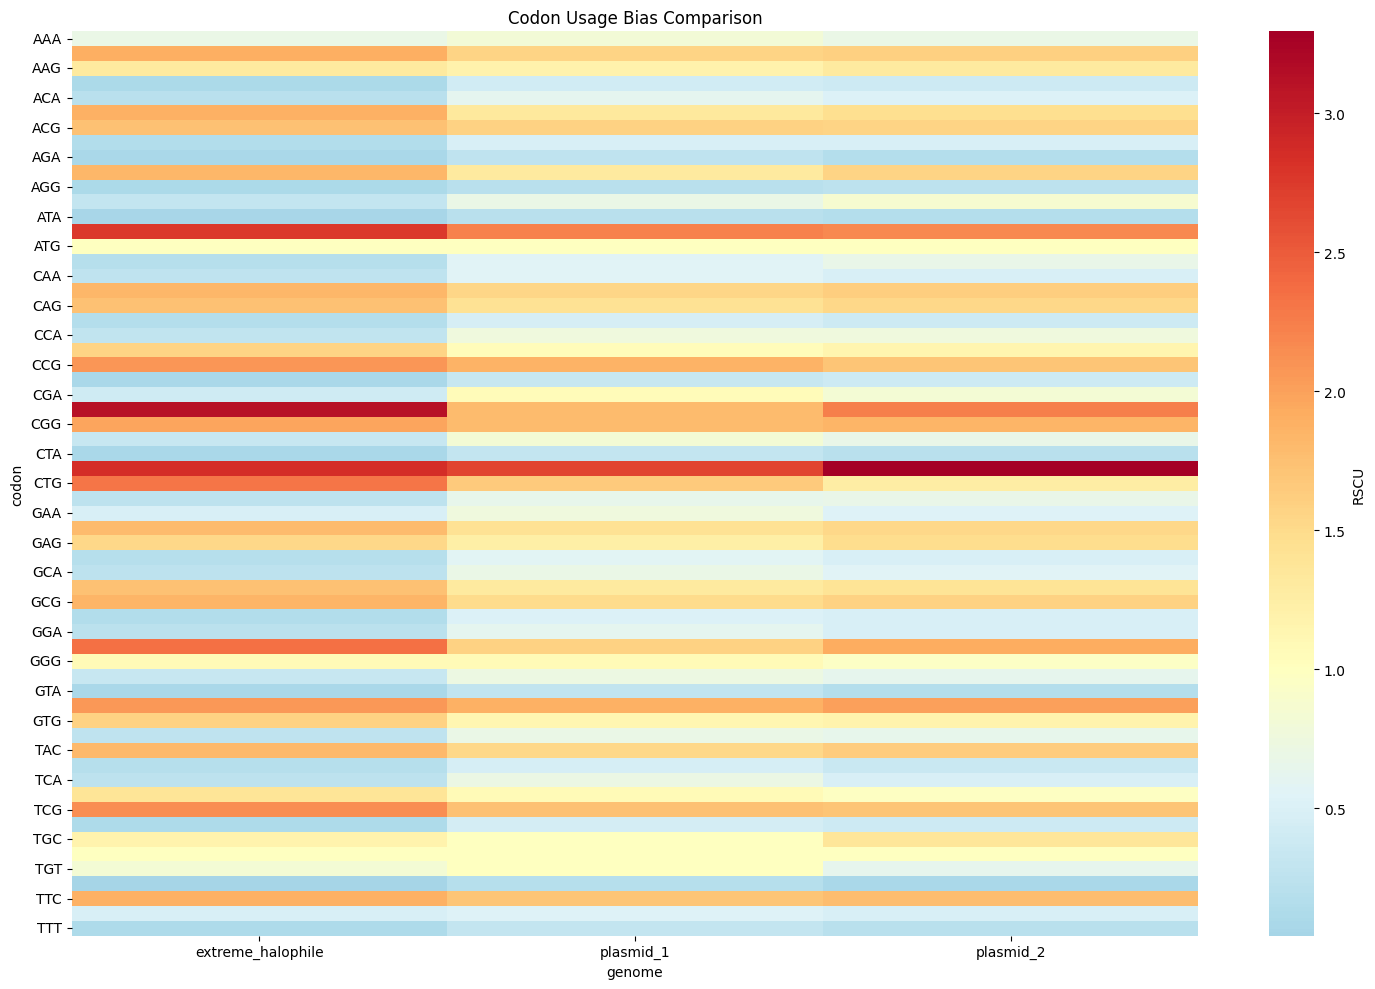

In [5]:
import pandas as pd
import numpy as np
from Bio import Entrez, SeqIO
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class ComparativeGenomics:
    def __init__(self):
        self.reference_genomes = {
            'extreme_halophile': 'CP070377.1',    # Our halophile - this can be replaced with any other reference genome, change both the key and value eg: 'halobacterium_salinarum_NRC1': 'NC_002607.1'
            'plasmid_1': 'CP070375.1',           # Plasmid 1 - this can be replaced with any other reference genome, change both the key and value
            'plasmid_2': 'CP070376.1'            # Plasmid 2 - this can be replaced with any other reference genome, change both the key and value
        }
        
        # Genetic code for translation of DNA to protein sequence based on NCBI table 11
        # link: https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi?chapter=tgencodes#SG11
        self.genetic_code = { 
            'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
            'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
            'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
            'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
            'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
            'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
            'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
            'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
            'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
            'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
            'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
            'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
            'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
            'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
            'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
            'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
        }
        
        # Patterns for different types of adaptations in halophiles
        # TODO: Add links to research papers for common patterns
        # TODO: Add/Refine patterns based on research
        self.adaptation_patterns = {
            'osmotic_regulation': [
                'sodium', 'potassium', 'chloride', 'transport', 
                'pump', 'antiport', 'symport', 'osmotic'
            ],
            'protein_stabilization': [
                'chaperone', 'folding', 'stability', 'protease',
                'heat shock', 'stress'
            ],
            'membrane_adaptation': [
                'membrane', 'lipid', 'carotene', 'pigment',
                'surface', 'wall'
            ]
        }
        
        self.aa_properties = {
            'acidic': ['D', 'E'],
            'basic': ['K', 'R', 'H'],
            'hydrophobic': ['A', 'I', 'L', 'M', 'F', 'W', 'V']
        }

    def fetch_genome(self, accession):
        """Fetch genome from NCBI"""
        try:
            handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()
            return record
        except Exception as e:
            print(f"Error fetching {accession}: {str(e)}")
            return None

    def fetch_and_analyze_genomes(self):
        """Fetch and analyze all reference genomes"""
        results = {}
        
        for name, accession in self.reference_genomes.items():
            print(f"\nAnalyzing {name} ({accession})...")
            
            # Fetch genome
            genome = self.fetch_genome(accession)
            if not genome:
                continue
            
            # Perform analyses
            results[name] = {
                'genome': genome,
                'basic_stats': self.analyze_basic_stats(genome),
                'gc_analysis': self.analyze_gc_patterns(genome),
                'protein_features': self.analyze_protein_features(genome),
                'codon_usage': self.analyze_codon_usage(genome),
                'adaptation_genes': self.analyze_adaptation_genes(genome)
            }
            
            # Print basic results
            print(f"Basic statistics for {name}:")
            for stat, value in results[name]['basic_stats'].items():
                print(f"  {stat}: {value}")
                
        return results

    def analyze_basic_stats(self, genome):
        """Calculate basic genome statistics"""
        stats = {
            'genome_size': len(genome.seq),
            'gc_content': (genome.seq.count('G') + genome.seq.count('C')) / len(genome.seq) * 100,
            'gene_count': sum(1 for f in genome.features if f.type == 'gene'),
            'protein_count': sum(1 for f in genome.features if f.type == 'CDS')
        }
        return stats

    def analyze_gc_patterns(self, genome, window_size=1000):
        """Analyze GC content distribution"""
        gc_data = []
        sequence = str(genome.seq)
        
        for i in range(0, len(sequence) - window_size, window_size):
            window = sequence[i:i + window_size]
            gc_content = (window.count('G') + window.count('C')) / len(window) * 100
            gc_data.append({
                'position': i,
                'gc_content': gc_content
            })
            
        return pd.DataFrame(gc_data)

    def analyze_adaptation_genes(self, genome):
        """Identify and analyze adaptation-related genes"""
        adaptation_genes = defaultdict(list)
        
        for feature in genome.features:
            if feature.type == 'CDS':
                product = feature.qualifiers.get('product', [''])[0].lower()
                
                for category, patterns in self.adaptation_patterns.items():
                    if any(pattern in product for pattern in patterns):
                        gene_info = {
                            'product': product,
                            'location': str(feature.location),
                            'length': len(feature.location)
                        }
                        adaptation_genes[category].append(gene_info)
        
        return dict(adaptation_genes)

    def analyze_protein_features(self, genome):
        """Analyze protein features and composition"""
        protein_data = []
        
        for feature in genome.features:
            if feature.type == 'CDS' and 'translation' in feature.qualifiers:
                sequence = feature.qualifiers['translation'][0]
                length = len(sequence)
                
                # Count amino acid types
                aa_counts = defaultdict(int)
                for aa in sequence:
                    aa_counts[aa] += 1
                
                # Calculate ratios
                acidic_count = sum(aa_counts[aa] for aa in self.aa_properties['acidic'])
                basic_count = sum(aa_counts[aa] for aa in self.aa_properties['basic'])
                hydrophobic_count = sum(aa_counts[aa] for aa in self.aa_properties['hydrophobic'])
                
                protein_data.append({
                    'length': length,
                    'acidic_ratio': acidic_count / length,
                    'basic_ratio': basic_count / length,
                    'hydrophobic_ratio': hydrophobic_count / length,
                    'acidic_basic_ratio': acidic_count / (basic_count if basic_count > 0 else 1)
                })
                
        return pd.DataFrame(protein_data)

    def analyze_codon_usage(self, genome):
        """Analyze codon usage patterns"""
        codon_counts = defaultdict(int)
        aa_counts = defaultdict(int)
        
        for feature in genome.features:
            if feature.type == 'CDS':
                try:
                    sequence = feature.extract(genome.seq)
                    sequence = sequence[:len(sequence) - (len(sequence) % 3)]
                    
                    for i in range(0, len(sequence), 3):
                        codon = str(sequence[i:i+3])
                        if codon in self.genetic_code:
                            codon_counts[codon] += 1
                            aa = self.genetic_code[codon]
                            aa_counts[aa] += 1
                except:
                    continue
        
        # Calculate RSCU
        rscu = self.calculate_rscu(codon_counts)
        
        return {
            'codon_counts': dict(codon_counts),
            'aa_counts': dict(aa_counts),
            'rscu': rscu
        }

    def calculate_rscu(self, codon_counts):
        """Calculate Relative Synonymous Codon Usage"""
        # Reference: https://link.springer.com/article/10.1007/BF02099948
        # > 1: codon is over-represented; < 1: codon is under-represented; = 1: codon is used as expected
        # codon over-representation indicates preference for that codon in translation
        # codon under-representation indicates preference for synonymous codons
        # RSCU = (Observed frequency of codon i) / (Expected frequency of codon i)
        rscu = {}
        for aa in set(self.genetic_code.values()):
            if aa == '*':
                continue
            
            aa_codons = [codon for codon, code_aa in self.genetic_code.items() if code_aa == aa]
            total_usage = sum(codon_counts[codon] for codon in aa_codons)
            
            if total_usage > 0:
                expected_usage = total_usage / len(aa_codons)
                for codon in aa_codons:
                    rscu[codon] = codon_counts[codon] / expected_usage if expected_usage > 0 else 0
                    
        return rscu

    def plot_comparative_analysis(self, results):
        """Generate comparative analysis plots"""
        self.plot_gc_distributions(results)
        self.plot_protein_features(results)
        self.plot_adaptation_genes(results)
        self.plot_codon_bias(results)

    def plot_gc_distributions(self, results):
        """Plot GC content distributions"""
        plt.figure(figsize=(12, 6))
        
        for name, data in results.items():
            gc_data = data['gc_analysis']
            plt.plot(gc_data['position'], gc_data['gc_content'], label=name)
            
        plt.xlabel('Genome Position')
        plt.ylabel('GC Content (%)')
        plt.title('GC Content Distribution Comparison')
        plt.legend()
        plt.show()

    def plot_protein_features(self, results):
        """Plot protein feature comparisons"""
        feature_data = []
        
        for name, data in results.items():
            protein_stats = data['protein_features']
            protein_stats['genome'] = name
            feature_data.append(protein_stats)
            
        combined_data = pd.concat(feature_data)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        sns.boxplot(data=combined_data, x='genome', y='acidic_ratio', ax=axes[0,0])
        axes[0,0].set_title('Distribution of Acidic Residues')
        
        sns.boxplot(data=combined_data, x='genome', y='basic_ratio', ax=axes[0,1])
        axes[0,1].set_title('Distribution of Basic Residues')
        
        sns.boxplot(data=combined_data, x='genome', y='hydrophobic_ratio', ax=axes[1,0])
        axes[1,0].set_title('Distribution of Hydrophobic Residues')
        
        sns.boxplot(data=combined_data, x='genome', y='acidic_basic_ratio', ax=axes[1,1])
        axes[1,1].set_title('Acidic/Basic Ratio Distribution')
        
        plt.tight_layout()
        plt.show()

    def plot_adaptation_genes(self, results):
        """Plot adaptation gene distributions"""
        gene_data = []
        
        for name, data in results.items():
            for category, genes in data['adaptation_genes'].items():
                gene_data.append({
                    'genome': name,
                    'category': category,
                    'count': len(genes)
                })
                
        df = pd.DataFrame(gene_data)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='genome', y='count', hue='category')
        plt.title('Distribution of Adaptation Genes')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_codon_bias(self, results):
        """Plot codon usage bias patterns"""
        codon_data = []
        
        for name, data in results.items():
            rscu_values = data['codon_usage']['rscu']
            for codon, rscu in rscu_values.items():
                codon_data.append({
                    'genome': name,
                    'codon': codon,
                    'RSCU': rscu
                })
                
        df = pd.DataFrame(codon_data)
        pivot_df = df.pivot(index='codon', columns='genome', values='RSCU')
        
        plt.figure(figsize=(15, 10))
        sns.heatmap(pivot_df, center=1, cmap='RdYlBu_r', 
                    cbar_kws={'label': 'RSCU'})
        plt.title('Codon Usage Bias Comparison')
        plt.tight_layout()
        plt.show()

def main():
    analyzer = ComparativeGenomics()
    Entrez.email = "chetan.elenki@gmail.com"  # Update with your email
    
    print("Starting comparative genomic analysis...")
    results = analyzer.fetch_and_analyze_genomes()
    
    print("\nGenerating visualizations...")
    analyzer.plot_comparative_analysis(results)
    
    return results

if __name__ == "__main__":
    results = main()